# 03 – Analysis and Visualization


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

This notebook presents a systematic analysis of all handshake experiments executed in the Key Exchange (KEX) performance evaluation framework.
It builds upon the parsed data from `02_parsing_and_exploration.ipynb`, consolidating runtime metrics, resource usage, and experiment metadata.
The data includes multiple experiments across three KEX modes (`classic`, `hybrid`, `pqc`) and two execution environments (`docker`, `native`), under various network profiles.


## 1. Introduction

### Objectives

The main objectives of this analysis are:

- Determine which key exchange variant performs best in terms of handshake duration and resource usage.
- Assess the impact of constrained network profiles on handshake performance taking into account the key exchange algorithm
- Compare the behavior of Docker-based versus native execution environments.
- Analyze the CPU and RAM usage across different modes and setups.
- Examine handshake stability under various simulated conditions.


### Research Questions

- How does a hybrid key exchange approach impact handshake efficiency under varying network conditions?
- What performance trade-offs exist between classical, hybrid, and post-quantum key exchange modes?
- Is Docker-based execution significantly different in terms of timing and system resource usage compared to native execution?
- How stable and robust are the different key exchange variants when deployed under constrained network profiles?

## 2. Methodology

This section outlines the experimental setup, including the execution environments, the applied network profiles, and the measurement approach.

Experiments were executed using both Docker-based containers and native Python processes. Simulated network conditions were applied using `tc netem` in the Docker setup to reflect realistic latency, packet loss, and bandwidth constraints.

### 2.1 Execution Environments

Two environments were used to run the experiments:

- **Docker**: Client and server were executed in isolated containers connected via a custom bridge network. Network manipulation using `tc netem` was applied directly inside the server container.
- **Native**: Client and server were executed as native Python processes on the host system without additional containerization or artificial network constraints.

Note: Only `experiment_01` was executed in both environments and can therefore be used for direct Docker vs. Native comparison.


### 2.2 Network Profiles

To simulate constrained or realistic environments, six network profiles were defined and applied to the Docker-based experiments via `tc netem`. These profiles emulate common real-world scenarios such as mobile networks, WiFi, and satellite communication.

Each profile defines parameters for:

- **Delay** (one-way latency per packet)
- **Packet loss** (random drop probability)
- **Rate limiting** (maximum bandwidth)
- **Burst and latency buffer** (for TBF shaping)

The profiles were applied to `experiment_02` through `experiment_06`. The native setup did not include artificial constraints.


| Experiment ID | Profile Name         | Delay | Packet Loss | Bandwidth | Burst  | Latency Buffer |
|---------------|----------------------|--------|--------------|-----------|--------|----------------|
| experiment_01 | None (baseline)      | —      | —            | —         | —      | —              |
| experiment_02 | netem_mobile         | 150ms  | 3%           | 700kbit   | 32kbit | 500ms          |
| experiment_03 | netem_lan            | 200ms  | 0%           | —         | —      | —              |
| experiment_04 | netem_package_loss   | 50ms   | 10%          | —         | —      | —              |
| experiment_05 | netem_good_wlan      | 30ms   | 0.5%         | 5mbit     | 64kbit | 200ms          |
| experiment_06 | netem_satelite       | 30ms   | 0.5%         | 5mbit     | 64kbit | 200ms          |

### 2.3 Hardware

All experiments were conducted locally on the following hardware:

- **Device**: MacBook Pro (Apple Silicon)
- **Chip**: Apple M4 Pro
- **Memory**: 24GB Unified Memory
- **CPU**: 12-core
- **GPU**: 16-core

Both Docker and native processes were executed on the same machine under low system load to ensure reproducibility and consistency.


## 3. Client vs. Server Duration Comparison

This section investigates the differences between the handshake duration measured by the client and the server.

Since both sides log their own timing independently, analyzing the gap between these values helps understand whether:

- network latency is accurately reflected in the measurements,
- one side systematically under- or overestimates the handshake duration,
- client-side and server-side processing times differ by key exchange mode.

In [3]:
#Load dataframe from csv (created in previous notebook)
df_all = pd.read_csv("../data/all_measurements.csv")

In [4]:
# Filter only relevant columns for merging
client_df = df_all[df_all["side"] == "client"][["experiment", "setup", "mode", "duration_sec"]].copy()
client_df = client_df.rename(columns={"duration_sec": "duration_client"})

server_df = df_all[df_all["side"] == "server"][["experiment", "setup", "mode", "duration_sec"]].copy()
server_df = server_df.rename(columns={"duration_sec": "duration_server"})

In [5]:
# Merge client and server logs row-wise by experiment/setup/mode
df_merged = pd.merge(client_df, server_df, on=["experiment", "setup", "mode"])

# Calculate absolute and relative difference
df_merged["abs_diff"] = (df_merged["duration_client"] - df_merged["duration_server"]).abs()
df_merged["rel_diff"] = df_merged["abs_diff"] / df_merged[["duration_client", "duration_server"]].max(axis=1)

We calculate both the absolute and relative difference in handshake duration between client and server, grouped by mode and experiment.

This helps identify whether one side consistently reports higher durations and whether the gap depends on the network profile or execution mode.


In [6]:
df_diff_summary = (
    df_merged
    .groupby(["setup", "experiment", "mode"])[["duration_client", "duration_server", "abs_diff", "rel_diff"]]
    .median()
    .reset_index()
)

df_diff_summary

,setup,experiment,mode,duration_client,duration_server,abs_diff,rel_diff
0,docker,experiment_01,classic,0.000230,0.000113,0.000107,0.500000
1,docker,experiment_01,hybrid,0.000286,0.000244,0.000046,0.160808
2,docker,experiment_01,pqc,0.000205,0.000121,0.000091,0.423402
3,docker,experiment_02,classic,0.307870,0.154496,0.153761,0.499354
4,docker,experiment_02,hybrid,0.308751,0.155490,0.153503,0.497283
5,docker,experiment_02,pqc,0.308323,0.154585,0.153967,0.499370
6,docker,experiment_03,classic,0.408155,0.204739,0.203591,0.498703
7,docker,experiment_03,hybrid,0.410920,0.206668,0.204335,0.497467
8,docker,experiment_03,pqc,0.408299,0.204730,0.203722,0.498793
9,docker,experiment_04,classic,0.108011,0.054715,0.054384,0.503523


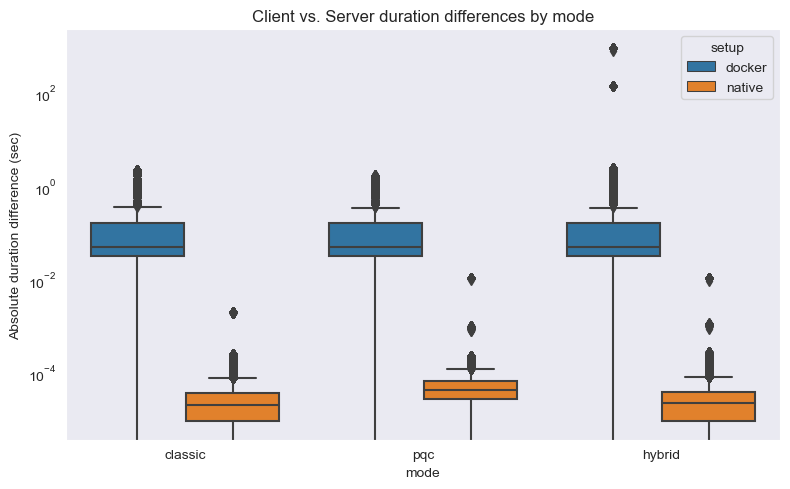

In [7]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_merged,
    x="mode",
    y="abs_diff",
    hue="setup"
)
plt.ylabel("Absolute duration difference (sec)")
plt.title("Client vs. Server duration differences by mode")
plt.grid(axis='y')
plt.yscale("log")
plt.tight_layout()
plt.show()

### Interpretation: Client vs. Server Duration Differences

The plot above shows the absolute difference in handshake duration as measured independently by the client and the server, grouped by key exchange mode and execution environment. The Y-axis is logarithmic to reveal both small and large differences.

#### Key Observations:

- **Docker setup consistently shows higher client-server discrepancies** compared to the native environment.
- The **native setup reports differences in the sub-millisecond range**, typically between `10^-4` and `10^-3` seconds.
- In contrast, **Docker-based runs often reach 10–100 milliseconds**, with some extreme outliers in the 100+ second range (likely due to outliers, network queuing, or logging delays).
- Across all modes (`classic`, `pqc`, `hybrid`), the **discrepancy pattern is consistent**: Docker > Native.

#### Explanation:

This discrepancy is likely due to the fact that **network emulation (`netem`) was applied only on the server container**, introducing artificial delay, bandwidth throttling, and packet loss:

- Since the **client measures round-trip time**, any server-side delay is included in the client's `duration_sec`.
- The **server, however, logs only its local processing time** and is unaware of any additional delay imposed on its own outbound or inbound traffic.
- This asymmetry explains why **client durations are often significantly higher** in Docker-based experiments.

#### Conclusion:

While the measurements from client and server are both valuable, **client-side durations provide a more comprehensive picture** in this setup, especially when `netem` is active. For comparative analysis and visualization, we therefore focus on client-side metrics unless explicitly noted.


## 4. Docker vs. Native Comparison


This section compares the performance of key exchange (KEX) algorithms in two different execution environments: **Docker** and **native (host)**.

We analyze:
- Duration of the key exchange
- CPU utilization
- RAM usage

### 4.1 Methodology

- Only **client-side measurements** are used in this section. These provide a complete picture of the key exchange process, including any network emulation delays.
- For each experiment we aggregate the client logs using **mean and median** statistics.
- The metrics are visualized across both execution environments.

> **Note:** Server-side metrics are excluded to ensure consistency, as `netem` was only applied to the server containers, leading to artificially skewed server-side results.


In [16]:
# Filter for experiment_01 and client side only
df_exp1_client = df_all[
    (df_all["experiment"] == "experiment_01") &
    (df_all["side"] == "client")
    ].copy()

df_exp1_client.groupby(["setup", "mode", "side"]).size().unstack()


side            client
setup  mode           
docker classic    1000
       hybrid     1000
       pqc        1000
native classic    1000
       hybrid     1000
       pqc        1000

### 4.2 Handshake Duration

In the following cell, we calculate and compare the **mean** and **median handshake durations** across the three KEX modes (`classic`, `pqc`, `hybrid`) for both Docker and Native setups.

This allows us to evaluate performance consistency and identify any systematic delays introduced by containerization.


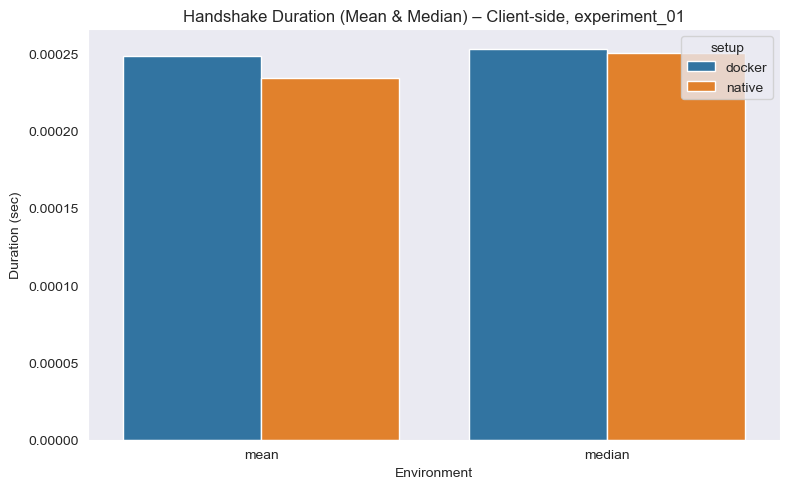

In [21]:
# Prepare data for seaborn (long format)
duration_stats = df_exp1_client.groupby(["setup"])["duration_sec"].agg(["mean", "median"]).reset_index()
duration_stats_long = duration_stats.melt(id_vars="setup", value_vars=["mean", "median"],
                                          var_name="metric", value_name="duration_sec")

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=duration_stats_long, x="metric", y="duration_sec", hue="setup")
plt.title("Handshake Duration (Mean & Median) – Client-side, experiment_01")
plt.ylabel("Duration (sec)")
plt.xlabel("Environment")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

The bar chart above shows the average (mean) and median handshake durations for both the Docker and Native setups, based solely on **client-side measurements** from experiment_01. Since this experiment was conducted **without network constraints (no `netem`)**, it offers a clean baseline comparison between the two environments.

#### Observations:

- **Durations across both environments are very close**, with only marginal differences in both mean and median values.
- The **Native setup is slightly faster on average**, as indicated by a lower mean duration compared to Docker.
- Interestingly, the **median for Native is slightly higher** than for Docker, indicating the presence of some outliers in the Docker runs that increased the average.

#### Interpretation:

- These small discrepancies suggest that, **in the absence of artificial network constraints**, Docker introduces minimal overhead for the handshake process.
- However, the difference in mean vs. median hints at **a slightly higher variability in Docker performance**, possibly due to container-level scheduling, I/O abstraction, or CPU allocation differences on macOS.
- Overall, **the environments behave comparably**, confirming that Docker can serve as a valid baseline for KEX performance evaluation, especially when controlling for outliers and focusing on medians.








### 4.3 CPU & RAM Comparison

The following bar plot shows the mean duration per key exchange mode, grouped by execution environment.


This section compares the system resource consumption of different Key Exchange (KEX) modes under Docker and native execution environments. Specifically, we analyze:

- **CPU usage** (`cpu_percent`)
- **RAM usage** (`ram_percent`)

Both metrics were recorded on the client side during each handshake and provide insights into the computational cost of each mode in both setups.

#### Methodology

- We use only **client-side logs from `experiment_01`**, where no artificial network constraints were applied.
- For each combination of environment (`docker`, `native`) we compute the **median** value of CPU and RAM usage.

In [29]:
# Group only by setup and compute median for CPU and RAM
resource_stats_summary = (
    df_exp1_client
    .groupby("setup")[["cpu_percent", "ram_percent"]]
    .mean()
    .reset_index()
    .melt(id_vars="setup", var_name="resource", value_name="percent")
)
resource_stats_summary

,setup,resource,percent
0,docker,cpu_percent,3.858067
1,native,cpu_percent,0.011400
2,docker,ram_percent,10.366667
3,native,ram_percent,73.366667


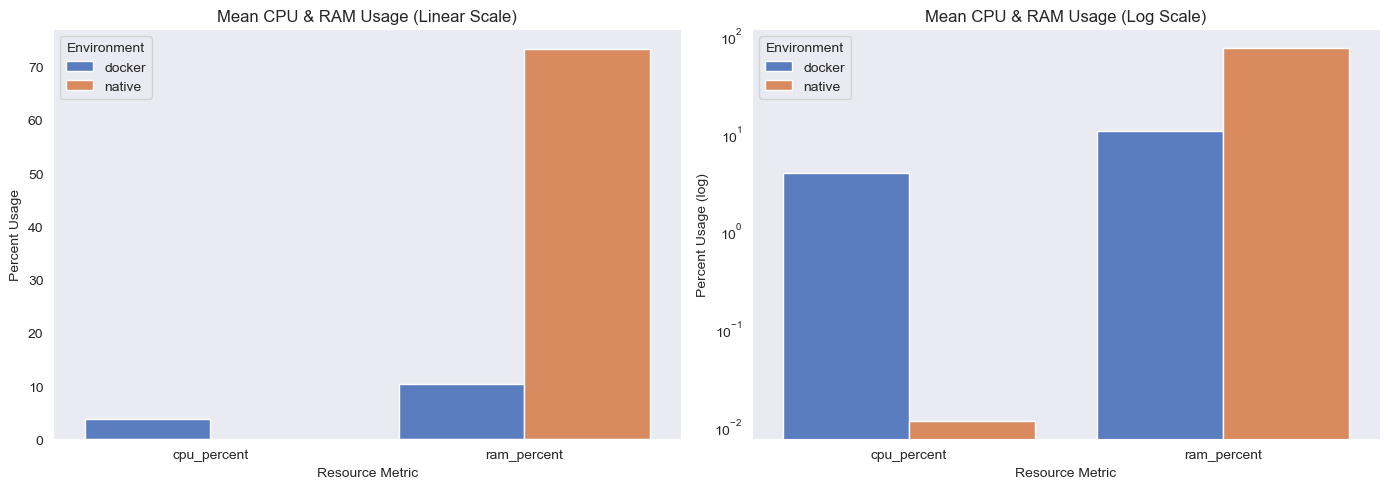

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# Plot 1: Linear scale
sns.barplot(data=resource_stats_summary, x="resource", y="percent", hue="setup", palette="muted", ax=axes[0])
axes[0].set_title("Mean CPU & RAM Usage (Linear Scale)")
axes[0].set_xlabel("Resource Metric")
axes[0].set_ylabel("Percent Usage")
axes[0].legend(title="Environment")
axes[0].grid(axis="y")

# Plot 2: Log scale
sns.barplot(data=resource_stats_summary, x="resource", y="percent", hue="setup", palette="muted", ax=axes[1])
axes[1].set_title("Mean CPU & RAM Usage (Log Scale)")
axes[1].set_xlabel("Resource Metric")
axes[1].set_ylabel("Percent Usage (log)")
axes[1].set_yscale("log")
axes[1].legend(title="Environment")
axes[1].grid(axis="y")

plt.tight_layout()
plt.show()

#### Observations

- **CPU usage** differs significantly between environments:
  - Docker: **3.86 %**
  - Native: **0.01 %**
  → Docker introduces substantial CPU overhead.

- **RAM usage** shows the opposite trend:
  - Docker: **10.37 %**
  - Native: **73.37 %**
  → Native consumes significantly more memory.

#### Interpretation

Although the Docker setup consumes **more CPU** and the native environment **more RAM**, the **measured handshake performance across modes is not affected in a meaningful way**:

- The **CPU load in Docker** is higher, but remains far below any threshold that would create a bottleneck or delay, especially since handshakes are brief and single-threaded.
- The **RAM consumption in the native setup**, while high in relative terms, does not appear to impact execution time — likely because the system still has sufficient headroom, and the extra usage may be tied to background processes or memory allocation patterns unrelated to the handshake itself.

Thus, the observed **performance differences between KEX modes (classic, hybrid, pqc)** are **comparable and valid across environments**.

> **Conclusion**: While absolute resource usage varies strongly between Docker and native setups, **this has no practical impact on the relative results of the experiments**. The comparisons between key exchange modes remain valid, regardless of execution environment.

#### Docker as the Preferred Environment

All experiments were executed in the **Docker environment** — intentionally and with good reason:

- **Reproducibility**: Docker provides a clean, isolated, and version-controlled environment, ensuring experiments can be reliably repeated on other machines or in the future.
- **Environment consistency**: No variation in software versions, system libraries, or dependencies, which could affect handshake behavior.
- **Scalability**: Multiple containers can be deployed in parallel for batch testing or simulations.
- **Portability**: The setup is easily shareable and runnable across Linux, macOS, and Windows.

Despite the **higher CPU usage**, Docker does **not compromise the validity or fairness** of the experimental results:

> **Conclusion**: The use of Docker introduces practical advantages without reducing the accuracy, comparability, or validity of the performance measurements. The results remain fully interpretable and meaningful across all KEX modes.


## 5. Comparison of Key Exchange Modes

This chapter compares the three key exchange variants — classical (ECDH), post-quantum (Kyber), and hybrid (ECDH + Kyber) — across several key dimensions: performance, resource consumption, and practical implementation complexity.

The goal is to provide a balanced view of the trade-offs between cryptographic security level and practical efficiency.

## 5.1 Methodology

This section describes the methodology used to compare the performance of three different key exchange (KEX) mechanisms: classical (ECDH), post-quantum (Kyber), and a hybrid approach combining both.

All measurements presented in this chapter are based on data collected from `experiment_01`. This experiment was executed without simulated network impairments, providing a clean and controlled environment to isolate the impact of the key exchange algorithm itself. The absence of latency, packet loss, or bandwidth restrictions ensures that the results reflect cryptographic and implementation-level differences rather than external network effects.

To ensure consistency and reproducibility, all experiments were conducted in the Docker-based setup. As shown in Chapter 4, Docker introduces a slightly higher CPU overhead compared to native execution. However, the decision to use Docker throughout this comparison is justified by the following considerations:

- **Environmental consistency**: All experiments run in an identical, containerized environment, eliminating interference from host-specific configurations or background processes.
- **Reproducibility**: The container setup ensures that the same results can be achieved across different machines and time points.
- **Automation and control**: Docker simplifies experimental automation, logging, and replication of test runs.
- **Portability**: The environment can be deployed across operating systems without modification.

Each KEX variant was evaluated using 1,000 handshake executions between a Docker-based client and server. The following metrics were recorded for each handshake:

- **Handshake duration** (in seconds)
- **CPU usage** (in percent)
- **RAM usage** (in percent)

The analysis in the subsequent sections compares the average and median values for each metric across the three KEX modes, with the objective of identifying practical performance trade-offs between classical, post-quantum, and hybrid key exchange strategies.

## 5.2 Handshake Duration per Mode

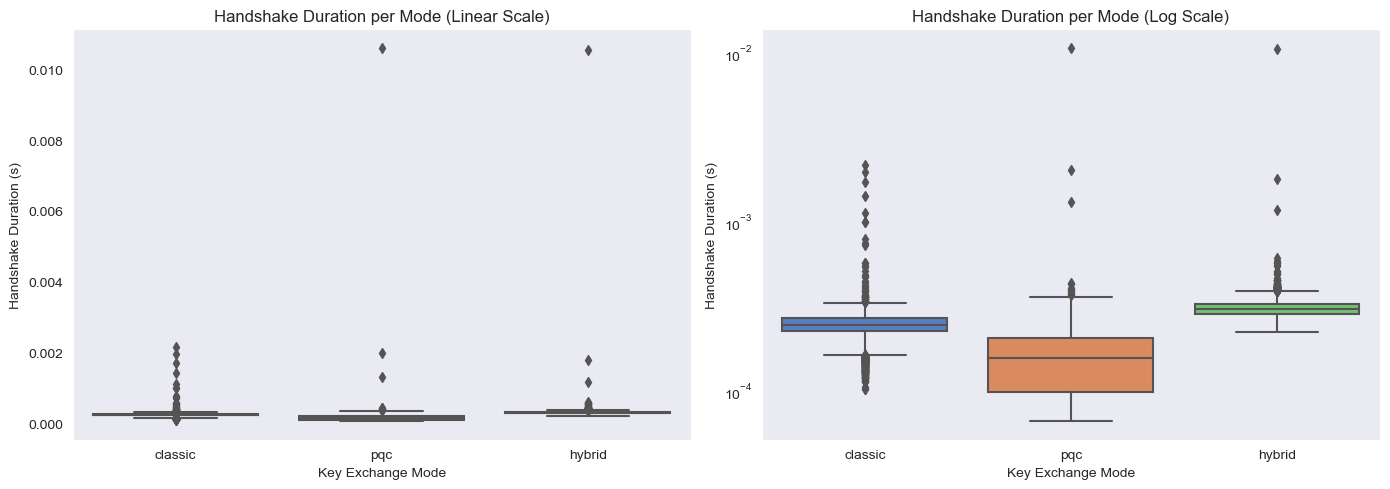

In [32]:
# Filter for client-side handshake data (if needed)
df_plot = df_exp1_client[df_exp1_client["side"] == "client"]

# Create two subplots: one with linear y-axis, one with logarithmic y-axis
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# Plot 1 – linear scale
sns.boxplot(data=df_plot, x="mode", y="duration_sec", palette="muted", ax=axes[0])
axes[0].set_title("Handshake Duration per Mode (Linear Scale)")
axes[0].set_xlabel("Key Exchange Mode")
axes[0].set_ylabel("Handshake Duration (s)")
axes[0].grid(axis='y')

# Plot 2 – logarithmic scale
sns.boxplot(data=df_plot, x="mode", y="duration_sec", palette="muted", ax=axes[1])
axes[1].set_title("Handshake Duration per Mode (Log Scale)")
axes[1].set_xlabel("Key Exchange Mode")
axes[1].set_ylabel("Handshake Duration (s)")
axes[1].set_yscale("log")
axes[1].grid(axis='y')

# Display the combined plot
plt.tight_layout()
plt.show()

The two boxplots above show the distribution of handshake durations for the three key exchange modes — classic (ECDH), pqc (Kyber), and hybrid — based on measurements from `experiment_01`.

The left-hand plot uses a linear y-axis, which emphasizes absolute differences in duration. The right-hand plot applies a logarithmic scale, revealing variations across several orders of magnitude, particularly in the tails of the distributions.

#### Observations

- All three modes show low median handshake durations in the sub-millisecond range.
- **Classic mode (ECDH)** has the tightest distribution, with few outliers.
- **PQC (Kyber)** shows a slightly broader spread with occasional low-duration outliers visible on the log scale.
- **Hybrid mode** exhibits a similarly concentrated distribution, with some notable outliers on both ends.
- In the linear-scale plot, the differences between the medians appear small; however, the log-scale view reveals a **greater spread** and highlights the presence of **occasional long-running handshakes**, particularly in the hybrid and pqc cases.

#### Interpretation

The results suggest that all three modes achieve very short and stable handshake durations under baseline conditions. However, the log-scaled plot shows that:

- **Kyber (pqc)** occasionally completes significantly faster than the median, likely due to favorable scheduling or minimal system interference during encapsulation.
- **Hybrid mode**, while generally stable, includes a small number of outliers with durations exceeding 10 ms. These may result from the cumulative cost of performing two key exchanges in parallel.

Overall, the performance differences are small in absolute terms but **relevant for time-critical applications** such as IoT, where even millisecond-level delays matter. Importantly, the **use of hybrid KEX does not introduce systemic latency**, but its increased cryptographic workload can occasionally cause longer handshakes in outlier cases.

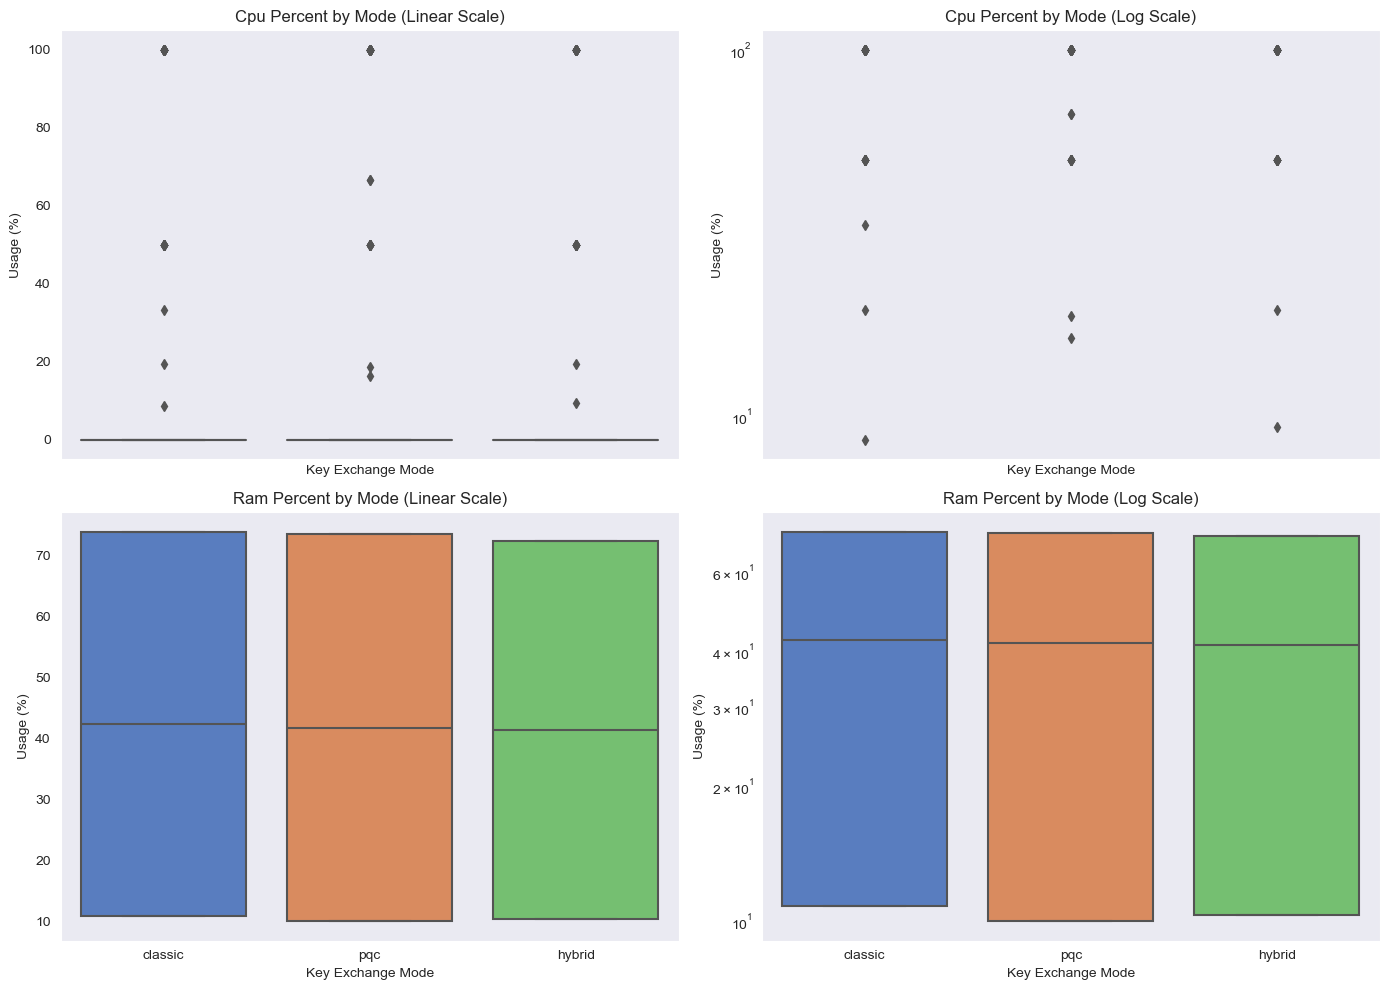

In [34]:
# Filter client-side measurements
df_plot = df_exp1_client[df_exp1_client["side"] == "client"]

# Set up 2x2 subplot matrix
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

# Plot titles and settings
resources = ["cpu_percent", "ram_percent"]
scales = ["linear", "log"]

for i, resource in enumerate(resources):
    for j, scale in enumerate(scales):
        ax = axes[i, j]
        sns.boxplot(data=df_plot, x="mode", y=resource, palette="muted", ax=ax)

        ax.set_title(f"{resource.replace('_', ' ').title()} by Mode ({scale.title()} Scale)")
        ax.set_xlabel("Key Exchange Mode")
        ax.set_ylabel("Usage (%)")
        ax.set_yscale(scale)
        ax.grid(axis="y")

plt.tight_layout()
plt.show()

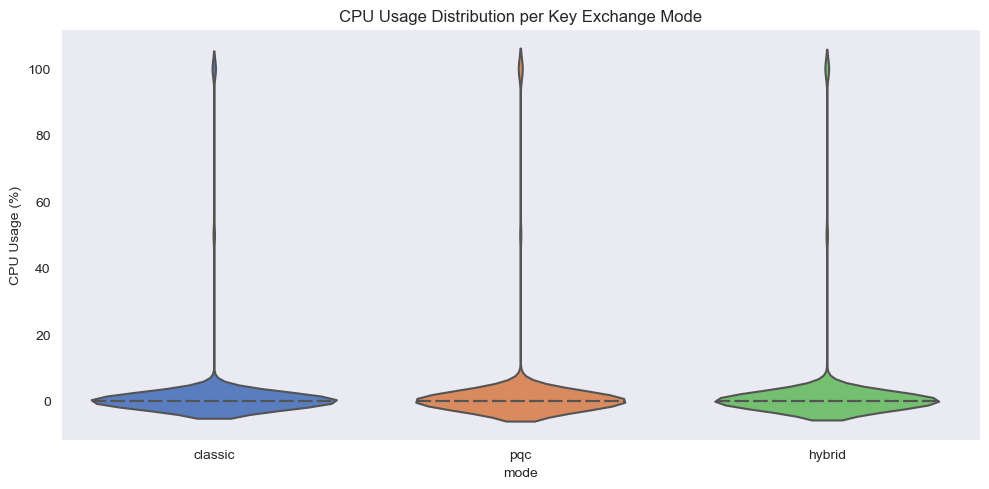

In [37]:
plt.figure(figsize=(10, 5))
sns.violinplot(data=df_plot, x="mode", y="cpu_percent", palette="muted", inner="quartile")
plt.title("CPU Usage Distribution per Key Exchange Mode")
plt.ylabel("CPU Usage (%)")
plt.grid(axis="y")
#plt.yscale("log")
plt.tight_layout()
plt.show()

/Users/luca/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


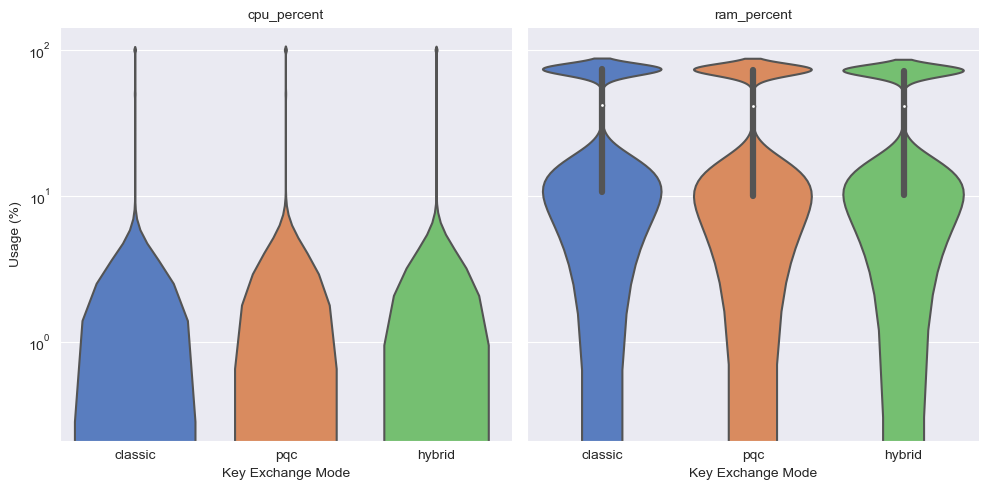

In [39]:
g = sns.catplot(
    data=df_plot.melt(id_vars=["mode"], value_vars=["cpu_percent", "ram_percent"],
                      var_name="resource", value_name="percent"),
    x="mode", y="percent", col="resource", kind="violin", inner="box", palette="muted",
    height=5, aspect=1
)
g.set_titles("{col_name}")
g.set_axis_labels("Key Exchange Mode", "Usage (%)")
g.set(yscale="log")

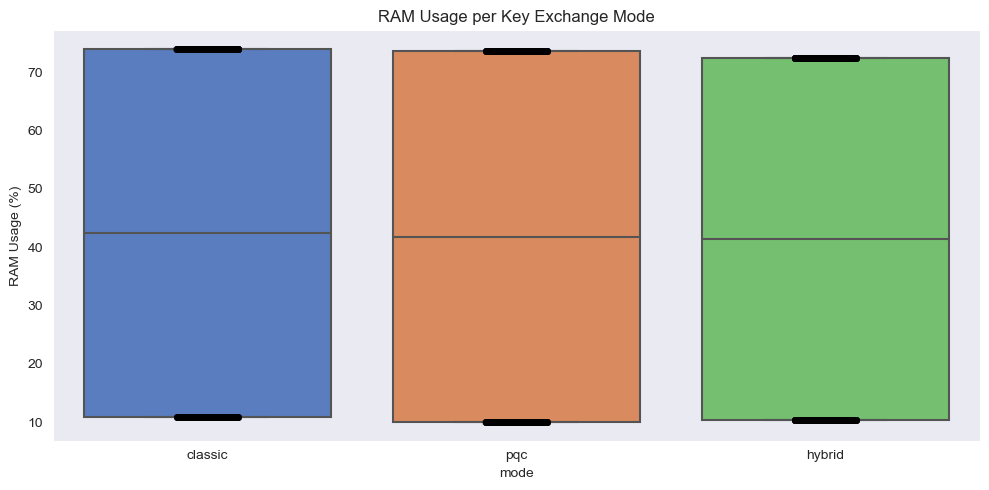

In [40]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_plot, x="mode", y="ram_percent", palette="muted")
sns.stripplot(data=df_plot, x="mode", y="ram_percent", color="black", alpha=0.3)
plt.title("RAM Usage per Key Exchange Mode")
plt.ylabel("RAM Usage (%)")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


## 6. Performance Comparison across Network Profiles

This chapter analyzes how each key exchange mode (classic, hybrid, pqc) performs under varying network conditions — including latency, jitter, and packet loss. It combines both handshake duration and resource usage (CPU & RAM) metrics to evaluate robustness and efficiency in less-than-ideal networking environments.

### 6.1 Overview of Network Profiles

- Summary of the configured network conditions in experiments 02–06.
- Table listing key parameters: latency, jitter, loss rate.
- Justification for their selection (e.g., simulating mobile, satellite, or unreliable networks).

### 6.2 Handshake Duration by Mode and Network Profile

- For each mode (classic, hybrid, pqc), show how handshake time changes under different conditions.
- Use line plots or grouped bar charts per mode.
- Highlight resilience or sensitivity.

### 6.3 Resource Usage by Mode and Network Profile

- Median or mean CPU and RAM usage under each profile.
- Discuss whether certain KEX modes scale worse under stress.
- Plot: Heatmap or grouped bars (mode × net-profile × metric).

### 6.4 Mode Robustness Summary

- Which mode is most stable in terms of handshake duration?
- Which mode is most resource-efficient under stress?
- Identify trade-offs: e.g., hybrid may be more stable, but slightly more RAM-hungry.
- Table or qualitative comparison (✓, ✗, →).

### 6.5 Interpretation and Practical Implications

- How do results affect the choice of KEX in constrained environments (e.g. IoT, high-latency links)?
- Does any mode break down under extreme network stress?
- Are the results consistent with cryptographic expectations (e.g., Kyber’s size vs ECDH’s compute cost)?
